# Telco Customer Churn Prediction

## Introduction
Customer churn is one of the most significant challenges in subscription-based industries such as telecom. This project builds a supervised machine learning model to estimate the probability that a customer will churn, and then uses those scores to support retention decisions.


## Dataset
The Telco Customer Churn dataset contains 7,043 customers and 21 features. Each row represents a customer and includes demographics, subscription details, and billing information.


## Objective
In this project I aim to:

- Perform exploratory data analysis (EDA)
- Clean and prepare the data for modeling
- Train and evaluate baseline vs. stronger models
- Select a final model and save the full preprocessing + model pipeline
- Use the saved pipeline in a Streamlit app for single-customer and batch scoring, plus a simple retention ROI simulation


In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import warnings; warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve
import os, joblib

df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.shape

(7043, 21)

In [142]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


The dataset includes 7043 entries and 21 features. Each row represents a unique customer.

**Data preview and schema check:** During development, I inspected a sample of rows and the data types to confirm the feature set and identify columns needing type conversion.

The dataset includes a mix of numerical and categorical variables. Most features are stored as object type, which suggest categorical encoding is required before modeling.

In [143]:
churn_counts = df['Churn'].value_counts()
churn_ratio  = df['Churn'].value_counts(normalize=True) * 100

print(churn_counts)
print(churn_ratio)

Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


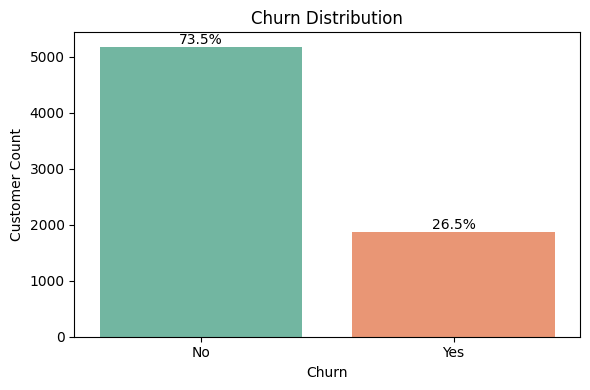

In [144]:
plt.figure(figsize=(6,4))

ax = sns.countplot(data=df, x='Churn', palette='Set2')

total = len(df)
for p in ax.patches:
    percentage = 100 * p.get_height() / total
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.show()

Approximately 26.5% of customers have churned, indicating a moderately imbalanced dataset. We suggest that evaluation metrics such as ROC-AUC and precision recall should be carefully considered.

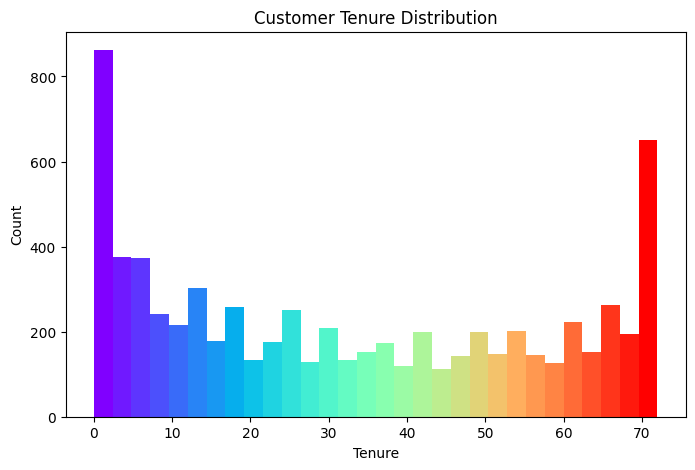

In [145]:
data = df['tenure']

counts, bins = np.histogram(data, bins=30)
colors = cm.rainbow(np.linspace(0, 1, len(counts)))

plt.figure(figsize=(8,5))

for count, bin_start, color in zip(counts, bins, colors):
    plt.bar(bin_start, count, width=bins[1]-bins[0], color=color, align='edge')

plt.title("Customer Tenure Distribution")
plt.xlabel("Tenure")
plt.ylabel("Count")
plt.show()

## Checking missing values


In [146]:
df.isnull().sum().sort_values(ascending=False)

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


No explicit missing values were detected using the standard check.

In [147]:
obj_cols = df.select_dtypes(include='object').columns

for col in obj_cols:
    print(col, "=", (df[col].astype(str).str.strip() == "").sum())

customerID = 0
gender = 0
Partner = 0
Dependents = 0
PhoneService = 0
MultipleLines = 0
InternetService = 0
OnlineSecurity = 0
OnlineBackup = 0
DeviceProtection = 0
TechSupport = 0
StreamingTV = 0
StreamingMovies = 0
Contract = 0
PaperlessBilling = 0
PaymentMethod = 0
TotalCharges = 11
Churn = 0


As we can see that there are 11 hidden missing values in the TotalCharges column stored as empty strings.

In [148]:
df.duplicated().sum()

np.int64(0)

No duplicate records were found in the dataset.

In [149]:
df.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


The TotalCharges column is stored as object instead of numeric, which requires correction before modeling.

## Data cleaning


Main preparation steps before modeling:

- Converted TotalCharges to numeric (some rows contain blank strings).
- Removed customerID because it is an identifier with no predictive value.
- Built a preprocessing pipeline:
  - Numeric features: median imputation + scaling
  - Categorical features: most-frequent imputation + one-hot encoding

This ensures the same transformations are applied consistently during training and later during Streamlit predictions.


In [150]:
df['TotalCharges'] = df['TotalCharges'].astype(str).str.strip()

df.loc[df['TotalCharges'] == '','TotalCharges'] =np.nan

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors ='coerce')

df.loc[df['tenure'] == 0,'TotalCharges'] = 0



There are 11 hidden missing values were identified in TotalCharges column. After these indications, some corrections have been made such as removing whitespace, replacing empty strings with NaN, converting to numaric, and logical imputation. These corresponded to customers with tenure equal to zero since newly acquired customers have not accumulated charges, these values were logically set to 0.

In [151]:
df.drop(columns=['customerID'], inplace=True)

The customerID column was removed as it does not provide predictive value.

In [152]:
df.isnull().sum().sum()

np.int64(0)

No missing values remain in the dataset after cleaning

In [153]:
df.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


The TotalCharges column is now correctly stored as a numeric variable.

In [154]:
df.shape

(7043, 20)

In [155]:
cat_cols = df.select_dtypes(include='object').columns

summary = pd.DataFrame({
    'Feature': cat_cols,
    'Unique Values': [df[col].nunique() for col in cat_cols]
})

summary.sort_values(by='Unique Values')

,Feature,Unique Values
0,gender,2
1,Partner,2
2,Dependents,2
3,PhoneService,2
13,PaperlessBilling,2
15,Churn,2
4,MultipleLines,3
5,InternetService,3
7,OnlineBackup,3
6,OnlineSecurity,3


In [156]:
for col in cat_cols:
    print(f"\n🔹 {col}")
    print(df[col].value_counts())
    print("-" * 40)


🔹 gender
gender
Male      3555
Female    3488
Name: count, dtype: int64
----------------------------------------

🔹 Partner
Partner
No     3641
Yes    3402
Name: count, dtype: int64
----------------------------------------

🔹 Dependents
Dependents
No     4933
Yes    2110
Name: count, dtype: int64
----------------------------------------

🔹 PhoneService
PhoneService
Yes    6361
No      682
Name: count, dtype: int64
----------------------------------------

🔹 MultipleLines
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
----------------------------------------

🔹 InternetService
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64
----------------------------------------

🔹 OnlineSecurity
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64
----------------------------------------

🔹 OnlineBackup
Onlin

Categorical variables were reviewed to ensure consistent labeling and identify potential anomalies before proceeding to exploratory analysis.

## Exploratory data analysis (EDA)


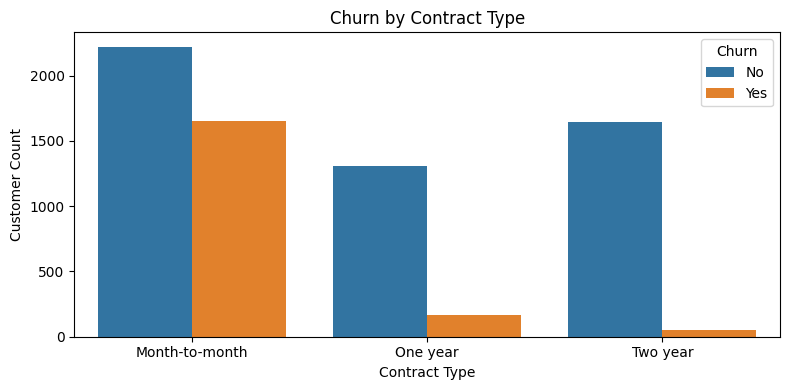

In [157]:
plt.figure(figsize=(8,4))
ax = sns.countplot(data=df, x='Contract', hue='Churn')
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Customer Count')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()


These graphs show that mont-to-month contracts have higher churn compared to one and two year contracts. It demonstrate that contract duration is a strong retention lever.

<Axes: >

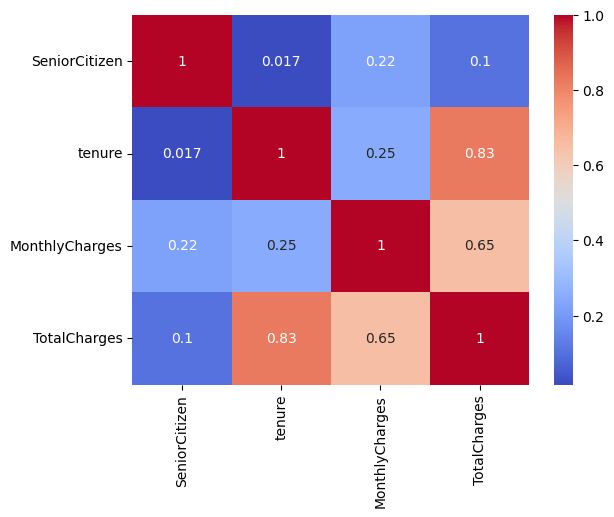

In [158]:
num_cols = df.select_dtypes(include=['int64','float64']).columns

sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')

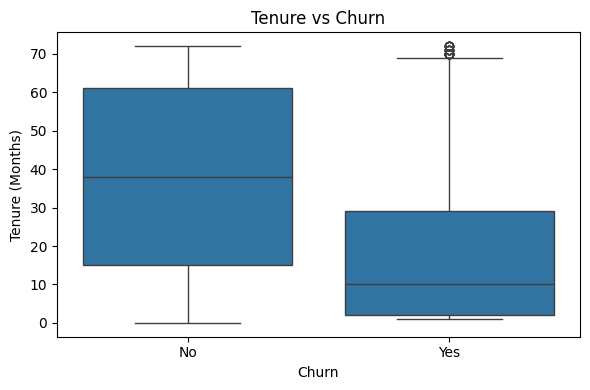

In [159]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Churn', y='tenure')
plt.title("Tenure vs Churn")
plt.xlabel("Churn")
plt.ylabel("Tenure (Months)")
plt.tight_layout()
plt.show()

Customers who churn tend to have shorter tenure, suggesting that early-stage customers are more likely to leave. This highlights the importance of onboarding and early engagement strategies.

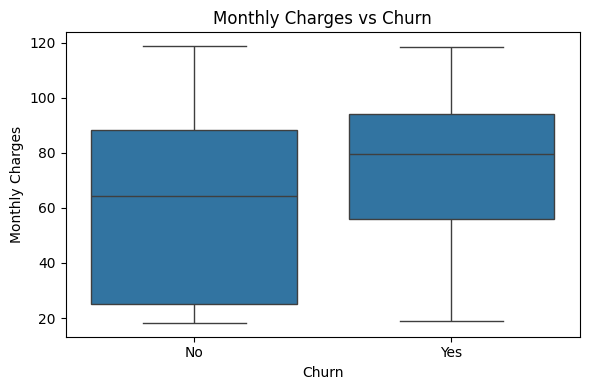

In [160]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges')
plt.title("Monthly Charges vs Churn")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.tight_layout()
plt.show()

Higher monthly charges appear to be associated with increased churn probability. Pricing sensitivity may play a role in customer retention.

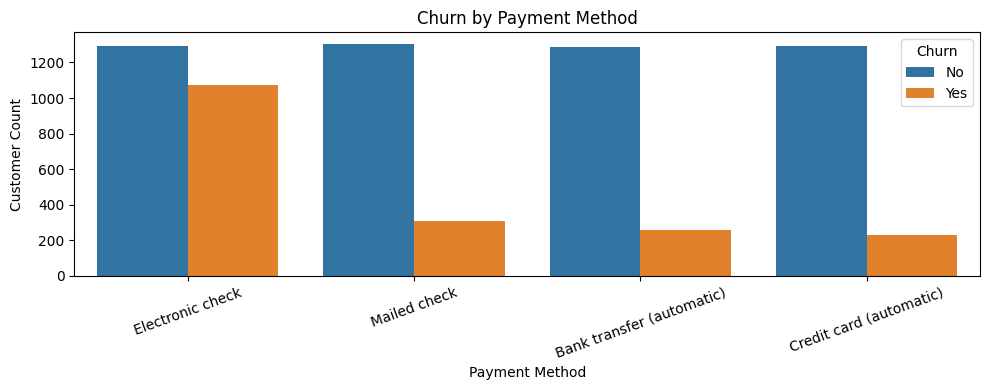

In [161]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='PaymentMethod', hue='Churn')
plt.title("Churn by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Customer Count")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

Certain payment methods show higher churn rates, indicating that payment behavior may correlate with customer risk segments.

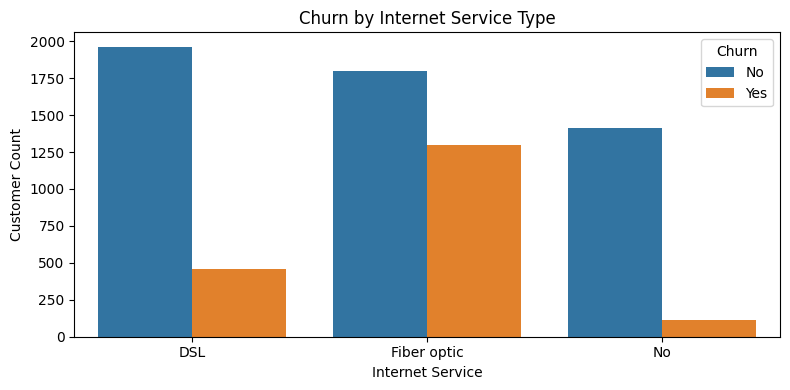

In [162]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='InternetService', hue='Churn')
plt.title("Churn by Internet Service Type")
plt.xlabel("Internet Service")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.show()

Churn patterns differ across internet service types, suggesting that service quality, pricing, or competition may influence customer decisions.

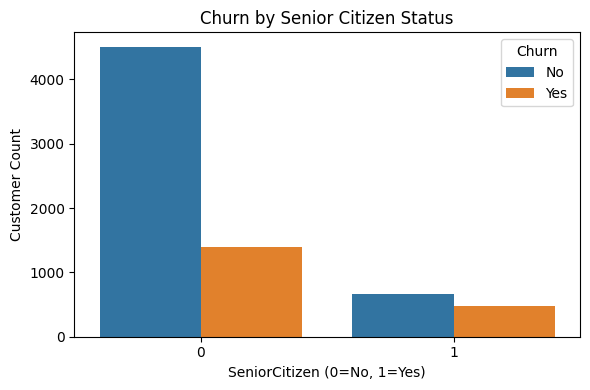

In [163]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='SeniorCitizen', hue='Churn')
plt.title("Churn by Senior Citizen Status")
plt.xlabel("SeniorCitizen (0=No, 1=Yes)")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.show()

Senior citizens show a slightly different churn pattern compared to non-senior customers, indicating potential demographic influences on retention.

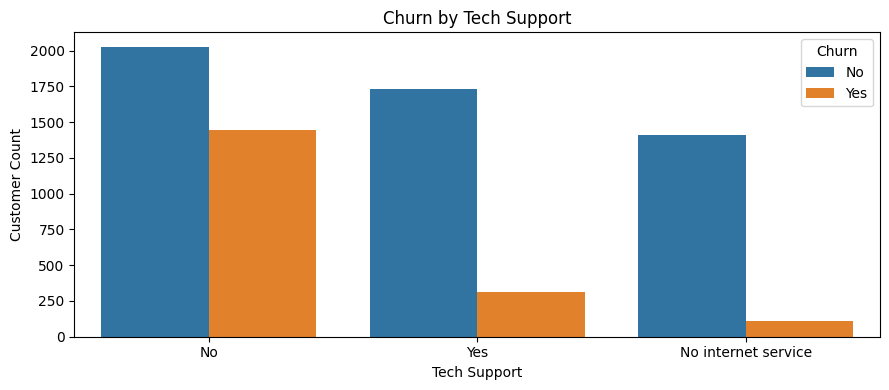

In [164]:
plt.figure(figsize=(9,4))
sns.countplot(data=df, x='TechSupport', hue='Churn')
plt.title("Churn by Tech Support")
plt.xlabel("Tech Support")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.show()

Customers with technical support services tend to churn less, suggesting that value-added services may improve customer retention.

In [165]:
rate_cols = ['Contract', 'InternetService', 'PaymentMethod', 'TechSupport']

for col in rate_cols:
    churn_rate = (
        pd.crosstab(df[col], df['Churn'], normalize='index')
        .rename(columns={'No':'Churn_No_Rate', 'Yes':'Churn_Yes_Rate'})
        .sort_values('Churn_Yes_Rate', ascending=False)
    )
    print(f"\n=== Churn Rate by {col} ===")
    display(churn_rate)


=== Churn Rate by Contract ===


Churn,Churn_No_Rate,Churn_Yes_Rate
Contract,,
Month-to-month,0.572903,0.427097
One year,0.887305,0.112695
Two year,0.971681,0.028319



=== Churn Rate by InternetService ===


Churn,Churn_No_Rate,Churn_Yes_Rate
InternetService,,
Fiber optic,0.581072,0.418928
DSL,0.810409,0.189591
No,0.925950,0.074050



=== Churn Rate by PaymentMethod ===


Churn,Churn_No_Rate,Churn_Yes_Rate
PaymentMethod,,
Electronic check,0.547146,0.452854
Mailed check,0.808933,0.191067
Bank transfer (automatic),0.832902,0.167098
Credit card (automatic),0.847569,0.152431



=== Churn Rate by TechSupport ===


Churn,Churn_No_Rate,Churn_Yes_Rate
TechSupport,,
No,0.583645,0.416355
Yes,0.848337,0.151663
No internet service,0.925950,0.074050


Segment-level churn rates provide clearer insight into high-risk customer groups and support targeted retention strategies.

## Key EDA insights (what we learned)

From the exploratory analysis, three patterns stand out:

1) Contract type is a strong churn driver: month-to-month customers churn much more than 1–2 year contracts.
2) Early-tenure customers are high risk: churn is concentrated among customers with lower tenure, suggesting onboarding and early engagement matter.
3) Price sensitivity exists: higher MonthlyCharges is associated with higher churn, which can be linked to perceived value or competitor pricing.

These insights also guide retention actions: target month-to-month + short tenure + higher monthly charge customers first.


## Supervised modeling


### Feature–target separation

The target variable is Churn, indicating whether a customer left the company. All remaining columns are treated as predictive features.


In [166]:
X = df.drop('Churn', axis=1)
y= df['Churn']

### Encode target variable


In [167]:
y= y.map({'No' : 0, 'Yes' : 1})

print('Target distribution:\n', y.value_counts())
print('Churn rate:',y.mean().round(3))

Target distribution:
 Churn
0    5174
1    1869
Name: count, dtype: int64
Churn rate: 0.265


### Train-test split


The dataset was split into training (80%) and test (20%) sets using stratified sampling to preserve the original churn distribution. This ensures reliable out-of-sample evaluation.

In [168]:
X_train,X_test,y_train,y_test =train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42)

print('Train shape', X_train.shape)
print('Test shape', X_test.shape)
print('Train churn rate',y_train.mean().round(3))
print('Test churn rate',y_test.mean().round(3))



Train shape (5634, 19)
Test shape (1409, 19)
Train churn rate 0.265
Test churn rate 0.265


### Preprocessing pipeline


In [169]:
num_cols = X_train.select_dtypes(include=['int64','float64']).columns
cat_cols = X_train.select_dtypes(include='object').columns

print('Numerical Columns',list(num_cols))
print('Categorical Columns',list(cat_cols))

Numerical Columns ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical Columns ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [170]:
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_transformer, num_cols),
        ('cat',categorical_transformer, cat_cols)
    ]
)

### Modeling approach

I start with Logistic Regression as a strong, interpretable baseline. Then I train Gradient Boosting to capture non-linear patterns and interactions.

Because churn is an imbalanced classification problem, I focus primarily on PR-AUC (Average Precision), and also report ROC-AUC for general separability. I also compare train vs. test performance to monitor overfitting.


### Baseline model: Logistic Regression


In [171]:
log_model = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier', LogisticRegression(max_iter=2000))
])

### Candidate model: Gradient Boosting


In [172]:
gb_model = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier',GradientBoostingClassifier(random_state=42))
])

### Model training


In [173]:
log_model.fit(X_train,y_train)
gb_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

### Evaluation


In [174]:
log_probs = log_model.predict_proba(X_test)[:, 1]
gb_probs  = gb_model.predict_proba(X_test)[:, 1]

print('Logistic Regression --- ROC-AUC:',round(roc_auc_score(y_test, log_probs), 4),
      '| PR-AUC:', round(average_precision_score(y_test, log_probs), 4))

print('Gradient Boosting --- ROC-AUC:',round(roc_auc_score(y_test, gb_probs), 4),
      '| PR-AUC:',round(average_precision_score(y_test, gb_probs), 4))


Logistic Regression --- ROC-AUC: 0.8421 | PR-AUC: 0.6343
Gradient Boosting --- ROC-AUC: 0.8434 | PR-AUC: 0.6604


In [175]:
# Overfitting check (train vs test gap)
log_train_probs = log_model.predict_proba(X_train)[:,1]
gb_train_probs  = gb_model.predict_proba(X_train)[:,1]

log_train_auc = roc_auc_score(y_train, log_train_probs)
log_test_auc  = roc_auc_score(y_test, log_probs)

gb_train_auc = roc_auc_score(y_train, gb_train_probs)
gb_test_auc  = roc_auc_score(y_test, gb_probs)

print(f"Logistic   Train ROC-AUC: {log_train_auc:.4f} | Test: {log_test_auc:.4f} | Gap: {(log_train_auc-log_test_auc):.4f}")
print(f"Gradient   Train ROC-AUC: {gb_train_auc:.4f} | Test: {gb_test_auc:.4f} | Gap: {(gb_train_auc-gb_test_auc):.4f}")

Logistic   Train ROC-AUC: 0.8493 | Test: 0.8421 | Gap: 0.0072
Gradient   Train ROC-AUC: 0.8822 | Test: 0.8434 | Gap: 0.0389


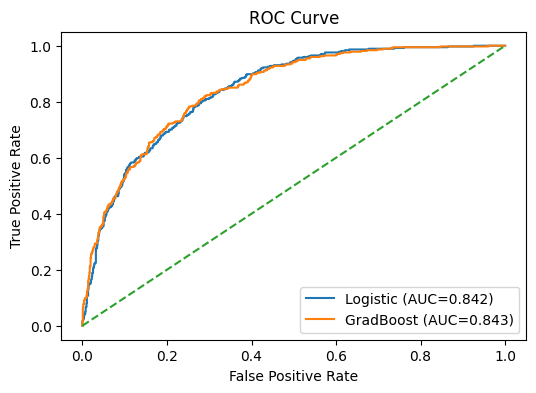

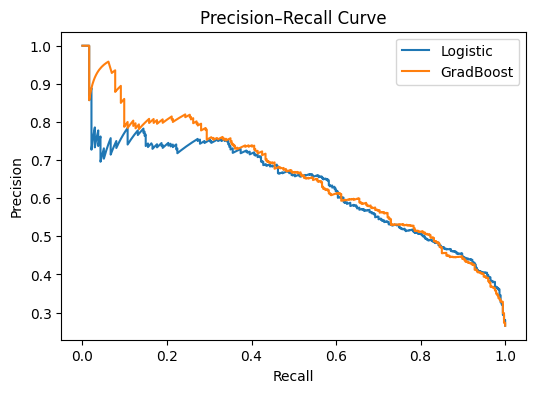

In [176]:
# ROC curves
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
fpr_gb,  tpr_gb,  _ = roc_curve(y_test, gb_probs)

plt.figure(figsize=(6,4))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC={auc(fpr_log,tpr_log):.3f})")
plt.plot(fpr_gb,  tpr_gb,  label=f"GradBoost (AUC={auc(fpr_gb,tpr_gb):.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision-Recall curves
prec_log, rec_log, _ = precision_recall_curve(y_test, log_probs)
prec_gb,  rec_gb,  _ = precision_recall_curve(y_test, gb_probs)

plt.figure(figsize=(6,4))
plt.plot(rec_log, prec_log, label="Logistic")
plt.plot(rec_gb,  prec_gb,  label="GradBoost")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

In [177]:
def eval_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs  = model.predict_proba(X_test)[:, 1]

    train_roc = roc_auc_score(y_train, train_probs)
    test_roc  = roc_auc_score(y_test, test_probs)
    gap_roc   = train_roc - test_roc

    train_pr = average_precision_score(y_train, train_probs)
    test_pr  = average_precision_score(y_test, test_probs)
    gap_pr   = train_pr - test_pr

    return {
        "Model": name,
        "Train ROC-AUC": round(train_roc, 4),
        "Test ROC-AUC": round(test_roc, 4),
        "ROC Gap": round(gap_roc, 4),
        "Train PR-AUC": round(train_pr, 4),
        "Test PR-AUC": round(test_pr, 4),
        "PR Gap": round(gap_pr, 4),
    }

rows = []


rows.append(eval_model("Logistic (baseline)", log_model, X_train, y_train, X_test, y_test))


gb_candidates = [
    ("GB (default)", GradientBoostingClassifier(random_state=42)),
    ("GB (lr=0.05, n=200, depth=3)", GradientBoostingClassifier(learning_rate=0.05, n_estimators=200, max_depth=3, random_state=42)),
    ("GB (lr=0.03, n=300, depth=3)", GradientBoostingClassifier(learning_rate=0.03, n_estimators=300, max_depth=3, random_state=42)),
]

for name, clf in gb_candidates:
    gb_pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ])
    rows.append(eval_model(name, gb_pipe, X_train, y_train, X_test, y_test))

results_df = pd.DataFrame(rows).sort_values(by=["Test PR-AUC", "Test ROC-AUC"], ascending=False)
results_df

,Model,Train ROC-AUC,Test ROC-AUC,ROC Gap,Train PR-AUC,Test PR-AUC,PR Gap
2,"GB (lr=0.05, n=200, depth=3)",0.8821,0.8441,0.0380,0.7410,0.6632,0.0778
3,"GB (lr=0.03, n=300, depth=3)",0.8791,0.8448,0.0343,0.7336,0.6631,0.0705
1,GB (default),0.8822,0.8434,0.0389,0.7406,0.6604,0.0802
0,Logistic (baseline),0.8493,0.8421,0.0072,0.6670,0.6343,0.0327


## Model selection (final choice)

Logistic Regression is stable and shows minimal overfitting. However, churn prediction is typically an imbalanced problem where the goal is to capture churners effectively, so PR-AUC is the more informative metric.

After tuning learning_rate and n_estimators, Gradient Boosting achieved higher PR-AUC while keeping the train–test gap small. For this reason, I select the tuned Gradient Boosting model as the final model used in the Streamlit application.


## Final model (tuned Gradient Boosting)

I use the tuned Gradient Boosting model as the final model because it achieved higher PR-AUC (more informative for churn) while keeping overfitting at an acceptable level.


In [178]:
final_model = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier',GradientBoostingClassifier(
        learning_rate= 0.03,
        n_estimators= 300,
        max_depth= 3,
        random_state=42
    ))
])

final_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_...),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.03,
                                            n_estimators=300,
                                            random_state=42))])

### Final model evaluation

I evaluate the final model using ROC-AUC and PR-AUC. PR-AUC is especially useful here because churn is an imbalanced target.


In [179]:
final_probs = final_model.predict_proba(X_test)[:, 1]

print('Final Gradient Boosting_ : ROC-AUC:', round(roc_auc_score(y_test, final_probs), 4))
print('Final Gradient Boosting : PR-AUC :', round(average_precision_score(y_test, final_probs), 4))

Final Gradient Boosting_ : ROC-AUC: 0.8448
Final Gradient Boosting : PR-AUC : 0.6631


In [180]:
scores_df = X_test.copy()
scores_df['y_true'] = y_test.values
scores_df['churn_proba'] =final_probs

scores_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,y_true,churn_proba
437,Male,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,...,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),114.05,8468.20,0,0.023367
2280,Female,1,No,No,8,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),100.15,908.55,0,0.823580
2235,Female,0,Yes,Yes,41,Yes,Yes,DSL,Yes,Yes,...,No,Yes,No,One year,Yes,Credit card (automatic),78.35,3211.20,0,0.065831
4460,Male,0,Yes,No,18,Yes,No,Fiber optic,No,No,...,Yes,No,No,Month-to-month,No,Electronic check,78.20,1468.75,0,0.329916
3761,Female,0,Yes,No,72,Yes,Yes,DSL,Yes,Yes,...,No,Yes,Yes,Two year,Yes,Credit card (automatic),82.65,5919.35,0,0.025999


## Retention targeting: threshold vs top-k


In [181]:
def target_by_threshold(df, threshold=0.35):
    out = df.copy()
    out["targeted"] = (out["churn_proba"] >= threshold).astype(int)
    return out

def target_by_topk(df, top_k_pct=0.10):
    out = df.copy().sort_values("churn_proba", ascending=False)
    k = int(np.ceil(len(out) * top_k_pct))
    out["targeted"] = 0
    out.iloc[:k, out.columns.get_loc("targeted")] = 1
    return out

## Retention targeting: threshold vs top-k


In [182]:
def retention_roi(df_scored,
                  success_rate=0.25,
                  contact_cost=2.0,
                  discount_cost=10.0,
                  expected_months_remaining=6):
  df=df_scored.copy()

  df['campaign_cost'] = df['targeted'] * (contact_cost + discount_cost)
  df['value_at_risk'] = df['MonthlyCharges'] * expected_months_remaining

  df['expected_saved_value'] = success_rate * df['targeted'] * df['y_true'] * df['value_at_risk']

  total_cost = df['campaign_cost'].sum()
  total_saved = df['expected_saved_value'].sum()
  net_profit = total_saved - total_cost

  return {
      'targeted_customers' : int(df['targeted'].sum()),
      'targeted_churners'  : int(((df['targeted'] == 1) & (df['y_true'] == 1)).sum()),
      'total_cost'         : round(total_cost, 2),
      'expected_saved_value': round(total_saved, 2),
      'net_profit'         : round(net_profit, 2)
      }




To find a best threshold for profit

In [183]:
thresholds = np.arange(0.10, 0.91, 0.05)

rows= []
for t in thresholds:
  tmp =target_by_threshold(scores_df,threshold=float(t))
  roi =retention_roi(tmp, success_rate=0.25, contact_cost=2.0,discount_cost=10.0, expected_months_remaining=6)
  rows.append({'threshold': float(t),**roi})

roi_threshold_df = pd.DataFrame(rows).sort_values('net_profit',ascending=False)
roi_threshold_df.head(10)


,threshold,targeted_customers,targeted_churners,total_cost,expected_saved_value,net_profit
0,0.10,862,351,10344.0,38743.95,28399.95
1,0.15,746,333,8952.0,37236.75,28284.75
2,0.20,647,315,7764.0,35191.57,27427.57
3,0.25,585,300,7020.0,33390.45,26370.45
4,0.30,526,283,6312.0,31817.62,25505.62
5,0.35,470,265,5640.0,30092.55,24452.55
6,0.40,409,242,4908.0,27674.10,22766.10
7,0.45,343,215,4116.0,24866.78,20750.78
8,0.50,282,191,3384.0,21952.28,18568.28
9,0.55,239,168,2868.0,19550.32,16682.32


To find a best top-k for profit

In [184]:
topk_list = [0.05, 0.10, 0.15, 0.20, 0.30]

rows = []
for k in topk_list:
    tmp = target_by_topk(scores_df, top_k_pct=k)
    roi = retention_roi(tmp, success_rate=0.25, contact_cost=2.0, discount_cost=10.0, expected_months_remaining=6)
    rows.append({"top_k_pct": k, **roi})

roi_topk_df = pd.DataFrame(rows).sort_values("net_profit", ascending=False)
roi_topk_df

,top_k_pct,targeted_customers,targeted_churners,total_cost,expected_saved_value,net_profit
4,0.30,423,247,5076.0,28185.00,23109.00
3,0.20,282,191,3384.0,21952.28,18568.28
2,0.15,212,153,2544.0,17875.50,15331.50
1,0.10,141,108,1692.0,12857.25,11165.25
0,0.05,71,58,852.0,7100.85,6248.85


In [185]:
best_threshold = roi_threshold_df.iloc[0]["threshold"]
best_topk = roi_topk_df.iloc[0]["top_k_pct"]

print("Best threshold:", best_threshold)
print("Best top-k %  :", best_topk)

Best threshold: 0.1
Best top-k %  : 0.3


## Deployment (Streamlit)

The final preprocessing + model pipeline is saved with **joblib** and loaded in a Streamlit app. This allows:

- Single-customer scoring (one-row CSV)
- Batch scoring (CSV upload with churn probabilities)
- A simple retention ROI simulation layer using the predicted churn probabilities


In [186]:
os.makedirs("models", exist_ok=True)
joblib.dump(final_model, "models/churn_pipeline.joblib")

print("Saved -> models/churn_pipeline.joblib")

Saved -> models/churn_pipeline.joblib


###Conclusion & Next Steps

In this project, I built a complete churn prediction pipeline starting from raw data cleaning to model deployment. I first explored the dataset and analyzed the distribution of churn across different features such as contract type, tenure, and monthly charges. This helped me understand which variables are likely to influence customer churn.

I compared Logistic Regression and Gradient Boosting as baseline and advanced models. While Logistic Regression provided a solid and interpretable baseline, Gradient Boosting achieved better performance in terms of ROC-AUC and PR-AUC, especially in capturing more complex patterns in the data. After tuning and evaluating both models on the test set, I selected Gradient Boosting as the final model.

To make the project more practical, I deployed the trained pipeline using Streamlit. The application allows single-customer scoring, batch scoring, and a simple retention ROI simulation. This step helped me understand how machine learning models can move from experimentation to real-world use.

For future improvements, I would like to experiment with additional feature engineering, cost-sensitive learning, and more advanced models such as XGBoost. I would also explore model explainability techniques to better understand individual churn predictions.